In [1]:
import pickle
import os
import re
import pandas as pd
import numpy as np

In [2]:
from gensim.models.doc2vec import Doc2Vec
import numpy, math

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
from tqdm import tqdm
tqdm.pandas(desc="progress-bar")
from gensim.models import Doc2Vec
from sklearn import utils
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from gensim.models.doc2vec import TaggedDocument

C:\Users\morad\Anaconda3\lib\site-packages\tqdm\std.py:648: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


### ALL info for repos

In [5]:
#the directory of pickle files
usr_dir = r'C:\GH-Dataset\Git_dt_roles\users'

In [6]:
#Load files in pickle format. There is a seperate pickle file per each developer.
def open_file(file_path):
    with open(file_path, "rb") as picklefile:
        reader = pickle.load(picklefile)
    return(reader)

In [7]:
#Seprate lines in text with \n only (replace other newline tags with \n)
def newline(text):
    return '\n'.join([p for p in re.split(r'\\n|\\r|\\n\\n|\\r\\n|\r\n', text) if len(p) > 0])

In [8]:
#merge a list of readme files in a single string which are seperated with \n 
def merg_RM(RM):
    return '\n '.join(RM)

In [9]:
#merge to texts in one single text
def merg_text(txt1,txt2):
    return txt1 +"\n "+txt2

In [18]:
#define the final DataFrame format
Corpus = pd.DataFrame(columns=['Name','u_id','bio','Repo_Name','ReadMe','tags','topics','textual_all'])

In [19]:
#loop over all files in a directory and collect required fields
for filename in os.listdir(usr_dir):
    file_path = os.path.join(usr_dir, filename)
    reader = open_file(file_path) 
    bio   = newline(str(reader['bio']))
    Name = str(reader['name'])
    try:
        u_id= str(reader['u_id'])
    except:
        u_id ="none"
        
    RM = []
    repo_name=[]
    repo_tags=[]
    repo_topics=[]
    repo_text=[]
    
    for row in range(0,len(reader['repository'])):
        repo_name_tmp = str(reader['repository'][row]['repo_name'])
        repo_RM_tmp = newline(str(reader['repository'][row]['readme']))
        repo_tags_tmp = str(reader['repository'][row]['topics'])
        repo_topics_tmp=newline(str(reader['repository'][row]['about']))
        
        repo_name.append(repo_name_tmp)
        RM.append(repo_RM_tmp)
        repo_tags.append(repo_tags_tmp)
        repo_topics.append(repo_topics_tmp)   
        
        repo_text_tmp = merg_text(merg_text(repo_tags_tmp,repo_topics_tmp),merg_text(repo_name_tmp,repo_RM_tmp))
        repo_text.append(repo_text_tmp)
        
        
        
    text_all = merg_RM(repo_text) 
    #info_all = merg_text(bio,text_all)
    
    
    Corpus = Corpus.append({'Name':Name,'u_id':u_id,'bio':bio,'Repo_Name':repo_name,'ReadMe':RM,'tags':repo_tags,
                            'topics':repo_topics,'textual_all':text_all},ignore_index=True)
    

In [20]:
len(Corpus)

1763

In [21]:
Corpus=Corpus[Corpus['u_id'].isin(lst_uid)].reset_index()

In [687]:
len(Corpus)

1578

In [688]:
dt1=Corpus[['Name','u_id','textual_all']]

In [24]:
dt2 = pd.read_csv('C:\GH-Dataset\Git_dt_roles\git_data_single_label.csv')

In [689]:
merged_inner = pd.merge(left=dt1, right=dt2[['gh_login','label']], left_on='u_id', right_on='gh_login')

In [690]:
txt_dt=merged_inner[['u_id','textual_all','label']]

In [691]:
len(txt_dt)

1272

In [28]:
import gensim
from gensim.parsing.preprocessing import *

In [29]:
#seperte sentences with \n
def split_sentence(corpus):
    sentences = [doc.split("\n") for doc in corpus]
    return sentences

In [30]:
#flat a list of lists into a list
def flatten_list(sentences):
    flatList = [ item.lower() for elem in sentences for item in elem]
    return flatList

In [31]:
#tokenize all sentences
def token_in_sentence(list_sentences):
    list_tokens = [list(gensim.utils.tokenize(doc, lower=True)) for doc in list_sentences]
    return list_tokens

In [32]:
#build a bundle of actions to clean data
def custom_filter():
    cstm_filter = [remove_stopwords,split_alphanum, strip_numeric, strip_tags, strip_non_alphanum]
    return cstm_filter

In [33]:
#cleaning data based on steps define in custom_filter
def str_preprocessing(tokenize_sentence):
    CUSTOM_FILTERS = custom_filter()
    tokens_new = preprocess_string(" ".join(tokenize_sentence), CUSTOM_FILTERS)
    return tokens_new

In [692]:
#split sentence in documents (Corpus['textual_all'])
sentences_stream = split_sentence(txt_dt['textual_all'])

In [693]:
#tokenize all sentences
tokenize_sentence=[]
for row in sentences_stream:
    tokenize_st = flatten_list(token_in_sentence(row))
    tokenize_sentence.append(tokenize_st)

In [694]:
#cleaning data with costum actions
processing_tokens = [str_preprocessing(sen) for sen in tokenize_sentence]

In [37]:
import nltk 

In [695]:
nltk.download('words')

[nltk_data] Downloading package words to
[nltk_data]     C:\Users\morad\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!


True

In [39]:
words = set(nltk.corpus.words.words())

In [40]:
english_tokens=[]
for row in processing_tokens:
    #clean_tokens.append([w for w in row if w not in ["None","none"]])
    english_tokens.append([w for w in row if w.lower() in words or not w.isalpha()])

In [696]:
clean_tokens=[]
for row in english_tokens:
    #clean_tokens.append([w for w in row if w not in ["None","none"]])
    clean_tokens.append([w for w in row if len(w) > 2])

In [697]:
flatten_tokenize=flatten_list(clean_tokens)

In [698]:
# number of tokens after cleaning process
len(flatten_tokenize)

8347916

In [699]:
#bigram model
bi_tmp_df = {'text_all':clean_tokens,'tags':txt_dt['u_id'],'label':txt_dt['label']}

In [700]:
bi_doc2vec_dt = pd.DataFrame(bi_tmp_df)

In [701]:
bi_doc2vec_dt=bi_doc2vec_dt[bi_doc2vec_dt['text_all'].str.len()>50].reset_index()

In [702]:
bi_doc2vec_dt=bi_doc2vec_dt.drop('index',axis=1)

In [41]:
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, precision_score, recall_score

In [732]:
doc_tagged = bi_doc2vec_dt.apply(
    lambda r: TaggedDocument(words=r['text_all'], tags=[r.tags]), axis=1)

In [733]:
%%time
model_dmm = Doc2Vec(dm=1, vector_size=230, window=5, negative=5, min_count=5,epochs=20)
model_dmm.build_vocab(tqdm(doc_tagged.values))

100%|█████████████████████████████████████████████████████████████████████████████| 1259/1259 [00:03<00:00, 397.83it/s]


Wall time: 7.98 s


In [734]:
model_dmm.train(tqdm(doc_tagged.values), total_examples=len(doc_tagged.values), epochs=model_dmm.epochs)

100%|█████████████████████████████████████████████████████████████████████████████| 1259/1259 [00:05<00:00, 240.52it/s]


In [735]:
y_all, X_all = vec_for_learning(model_dmm, doc_tagged)

In [710]:
all_tpc_kw_lib = pd.DataFrame(X_all)

In [716]:
all_tpc_kw_lib['label']=bi_doc2vec_dt['label']

In [720]:
len(all_tpc_kw_lib)

1259

In [722]:
all_vectors=all_tpc_kw_lib.drop('label',axis=1)

In [718]:
centroid=all_tpc_kw_lib.groupby('label').mean()

In [719]:
result= pd.DataFrame(columns=['sim','label','topic_label'])

In [723]:
for row in range(0,len(all_tpc_kw_lib)):
    label=all_tpc_kw_lib.iloc[row]['label']
    for i in range(0,len(centroid)):
        sims=cos_sim(all_vectors.iloc[row],centroid.iloc[i])
        result=result.append({'sim':sims,'label':label,'topic_label':centroid.index[i]},ignore_index=True)

In [726]:
rr=result.groupby(['label','topic_label'])['sim'].mean().reset_index()

In [728]:
all_fig = pd.DataFrame(0.0, index=centroid.index, columns=centroid.index)

In [729]:
for i in range(0,len(rr)):
    all_fig.loc[rr.iloc[i]['topic_label'],rr.iloc[i]['label']]=rr.iloc[i]['sim']

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

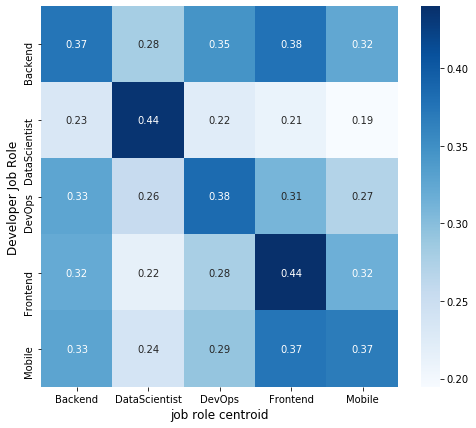

In [731]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(8,7))
ax = sns.heatmap(all_fig, cmap="Blues",annot=True) #notation: "annot" not "annote"
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.ylabel('Developer Job Role', fontsize=12)
plt.xlabel('job role centroid', fontsize=12)
plt.savefig('topic_key_correlation.png',dpi=150)

In [333]:
trainset, testset = train_test_split(bi_doc2vec_dt, test_size=0.1, random_state=44)

In [336]:
train = trainset.apply(
    lambda r: TaggedDocument(words=r['text_all'], tags=[r.tags]), axis=1)

In [337]:
test = testset.apply(
    lambda r: TaggedDocument(words=r['text_all'], tags=[r.tags]), axis=1)

In [7]:
import multiprocessing
cores = multiprocessing.cpu_count()

In [8]:
def evaluate_prediction(predictions, target, title="Confusion matrix"):
    print('accuracy %s' % accuracy_score(target, predictions))
    print('Testing F1 score: {}'.format(f1_score(target, predictions, average='weighted')))
    print('percision: {}'.format(precision_score(target, predictions, average='weighted')))
    print('recall: {}'.format(recall_score(target, predictions, average='weighted')))
    cm = confusion_matrix(target, predictions, labels=my_tags)
    print('confusion matrix\n %s' % cm)
    print('(row=expected, col=predicted)')
    
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plot_confusion_matrix(cm_normalized, title + ' Normalized')

In [9]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(my_tags))
    target_names = my_tags
    plt.xticks(tick_marks, target_names, rotation=45)
    plt.yticks(tick_marks, target_names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [10]:
my_tags = all_in_one.label.unique()

NameError: name 'all_in_one' is not defined

In [11]:
my_tags =['Frontend','Backend','Mobile','DataScientist','DevOps']

In [12]:
#Define the Cosine Similarity Function
def cos_sim(av,bv):
    return(sum(av*bv)/math.sqrt(sum(av*av)*sum(bv*bv)))

In [13]:
def vec_for_learning(model, tagged_docs):
    sents = tagged_docs.values
    model.random.seed(0)
    targets, regressors = zip(*[(doc.tags[0], model.infer_vector(doc.words, epochs=20)) for doc in sents])
    return targets, regressors

In [439]:
%%time
model_dmm = Doc2Vec(dm=1, vector_size=230, window=5, negative=5, min_count=5,epochs=20)
model_dmm.build_vocab(tqdm(train.values))

100%|█████████████████████████████████████████████████████████████████████████████| 1133/1133 [00:01<00:00, 823.90it/s]


Wall time: 5.62 s


In [440]:
model_dmm.train(tqdm(train.values), total_examples=len(train.values), epochs=model_dmm.epochs)

100%|█████████████████████████████████████████████████████████████████████████████| 1133/1133 [00:04<00:00, 251.63it/s]


In [441]:
%%time
y_train, X_train = vec_for_learning(model_dmm, train)
y_test, X_test = vec_for_learning(model_dmm, test)

Wall time: 3min 16s


In [442]:
Y_train,labels=zip(*[(label,label) for label in trainset['label']] )
Y_test,labels=zip(*[(label,label) for label in testset['label']] )

In [443]:
pd.DataFrame(Y_test)[0].value_counts()

Frontend         53
Mobile           37
DataScientist    17
Backend          11
DevOps            8
Name: 0, dtype: int64

In [444]:
u_id_lst=[]
for row in train.values:
    u_id_lst.append(row.tags[0])

In [445]:
sim_train=pd.DataFrame(columns=['u_id','cos_sim'])

In [446]:
for uid in range(0,len(u_id_lst)):
    vec_train=X_train[uid]
    username=u_id_lst[uid]
    vec_user = model_dmm.docvecs[username]
    sim_train=sim_train.append({'u_id':username,'cos_sim':cos_sim(vec_train,vec_user)},ignore_index=True)

In [447]:
#sim_train[sim_train['cos_sim']<0.85]

In [448]:
(len(sim_train)-len(sim_train[sim_train['cos_sim']<0.85]))/len(sim_train)

1.0

In [415]:
from sklearn.ensemble import RandomForestClassifier

In [449]:
rf = RandomForestClassifier(n_estimators = 100, random_state = 30)

In [450]:
rf.fit(X_train,Y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=30, verbose=0,
                       warm_start=False)

In [451]:
y_pred=rf.predict(X_test)

accuracy 0.5952380952380952
Testing F1 score: 0.5493227536396417
percision: 0.5767304651911402
recall: 0.5952380952380952
confusion matrix
 [[49  0  2  1  1]
 [ 3  1  4  1  2]
 [21  0 14  1  1]
 [ 4  0  2 11  0]
 [ 6  1  1  0  0]]
(row=expected, col=predicted)


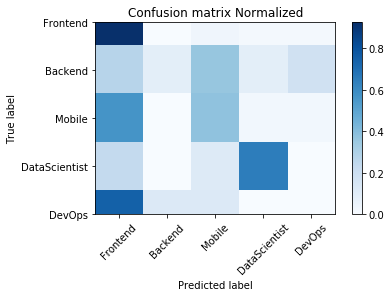

In [452]:
evaluate_prediction(y_pred, Y_test)

In [453]:
(p, r, f1, jac, hl, p_c,
         r_c, f1_c, s_c) = calculate_metrics(Y_test, y_pred,"macro")

In [454]:
fold_scores = {
            "precision": p,
            "recall": r,
            "f1": f1
        }


In [455]:
for i in range(0,len(label)):
            fold_scores["precision_{0}".format(label[i])] = p_c[i]
            fold_scores["recall_{0}".format(label[i])] = r_c[i]
            fold_scores["f1_{0}".format(label[i])] = f1_c[i]

In [456]:
fold_scores

{'precision': 0.4969542767342663,
 'recall': 0.4081749189407347,
 'f1': 0.4101556950323554,
 'precision_Backend': 0.5,
 'recall_Backend': 0.09090909090909091,
 'f1_Backend': 0.15384615384615385,
 'precision_DataScientist': 0.7857142857142857,
 'recall_DataScientist': 0.6470588235294118,
 'f1_DataScientist': 0.7096774193548386,
 'precision_DevOps': 0.0,
 'recall_DevOps': 0.0,
 'f1_DevOps': 0.0,
 'precision_Frontend': 0.5903614457831325,
 'recall_Frontend': 0.9245283018867925,
 'f1_Frontend': 0.7205882352941178,
 'precision_Mobile': 0.6086956521739131,
 'recall_Mobile': 0.3783783783783784,
 'f1_Mobile': 0.4666666666666667}

In [457]:
logreg = LogisticRegression(n_jobs=1, C=1e5)

In [458]:
logreg.fit(X_train, Y_train)
y_pred = logreg.predict(X_test)

C:\Users\morad\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\morad\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


accuracy 0.5079365079365079
Testing F1 score: 0.5245296379699804
percision: 0.5864497920380273
recall: 0.5079365079365079
confusion matrix
 [[27  8 10  2  6]
 [ 2  6  2  0  1]
 [ 5  9 13  4  6]
 [ 0  1  0 15  1]
 [ 2  1  1  1  3]]
(row=expected, col=predicted)


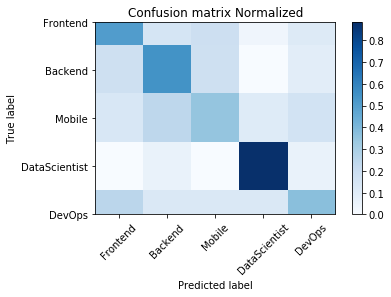

In [459]:
evaluate_prediction(y_pred, Y_test)

In [98]:
from sklearn import svm

In [460]:
clf = svm.SVC()

In [461]:
clf.fit(X_train, Y_train)

C:\Users\morad\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='rbf', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

In [462]:
y_pred = clf.predict(X_test)

In [463]:
#Y_test

accuracy 0.6190476190476191
Testing F1 score: 0.6077924605346608
percision: 0.6172360082134518
recall: 0.6190476190476191
confusion matrix
 [[42  3  5  2  1]
 [ 2  4  4  1  0]
 [15  4 16  2  0]
 [ 1  1  0 14  1]
 [ 3  2  1  0  2]]
(row=expected, col=predicted)


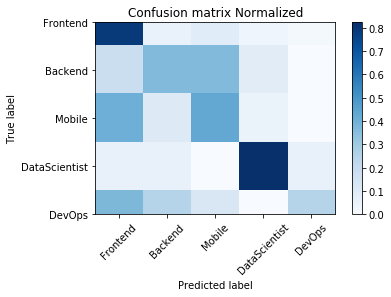

In [464]:
evaluate_prediction(y_pred, Y_test)

In [14]:
from sklearn.metrics import (auc, f1_score, hamming_loss, jaccard_score,
                             precision_recall_curve,
                             precision_recall_fscore_support, precision_score,
                             recall_score)

In [15]:

def calculate_metrics(Y_true, Y_pred,average):
    """Calculates the desired metrics for this study.

    This function receives both predicted and real output to calculate the 
    metrics used in this study.

    @param {Y_true} Ground truth's output
    @param {Y_pred} Prediction's output
    @param {Y_proba} Prediction's output in probability format

    @return a list with the metrics results used in our study
    """
    #if len(Y_true.shape) == 1:
        #Y_proba = Y_proba[:, 1]
    p, r, f1, s = precision_recall_fscore_support(
        Y_true, Y_pred)
    #pr, rr, _ = precision_recall_curve(Y_true.ravel(), Y_proba.ravel())

    scores = (
        precision_score(Y_true, Y_pred, average=average),
        recall_score(Y_true, Y_pred, average=average),
        f1_score(Y_true, Y_pred, average=average),
        jaccard_score(Y_true, Y_pred, average=average),
        hamming_loss(Y_true, Y_pred),
        p,
        r,
        f1,
        s
    )
    return scores

In [465]:
(p, r, f1, jac, hl, p_c,
         r_c, f1_c, s_c) = calculate_metrics(Y_test, y_pred,"macro")

In [434]:
#Y_test

In [466]:
fold_scores = {
            "precision": p,
            "recall": r,
            "f1": f1
        }


In [467]:
label=['Backend','DataScientist','DevOps','Frontend','Mobile']

In [468]:
for i in range(0,len(label)):
            fold_scores["precision_{0}".format(label[i])] = p_c[i]
            fold_scores["recall_{0}".format(label[i])] = r_c[i]
            fold_scores["f1_{0}".format(label[i])] = f1_c[i]

In [469]:
fold_scores

{'precision': 0.5609215346057451,
 'recall': 0.5324102076044361,
 'f1': 0.5326371100164203,
 'precision_Backend': 0.2857142857142857,
 'recall_Backend': 0.36363636363636365,
 'f1_Backend': 0.32,
 'precision_DataScientist': 0.7368421052631579,
 'recall_DataScientist': 0.8235294117647058,
 'f1_DataScientist': 0.7777777777777778,
 'precision_DevOps': 0.5,
 'recall_DevOps': 0.25,
 'f1_DevOps': 0.3333333333333333,
 'precision_Frontend': 0.6666666666666666,
 'recall_Frontend': 0.7924528301886793,
 'f1_Frontend': 0.7241379310344827,
 'precision_Mobile': 0.6153846153846154,
 'recall_Mobile': 0.43243243243243246,
 'f1_Mobile': 0.5079365079365079}

In [738]:
#define the final DataFrame format
avg_Corpus = pd.DataFrame(columns=['Name','u_id','bio','Repo_Name','ReadMe','textual_all'])

In [739]:
#loop over all files in a directory and collect required fields
for filename in os.listdir(usr_dir):
    file_path = os.path.join(usr_dir, filename)
    reader = open_file(file_path) 
    bio   = newline(str(reader['bio']))
    Name = str(reader['name'])
    try:
        u_id= str(reader['u_id'])
    except:
        u_id ="none"
        
    RM = []
    repo_name=[]
    repo_tags=[]
    repo_topics=[]
    repo_text=[]
    
    for row in range(0,len(reader['repository'])):
        repo_name_tmp = str(reader['repository'][row]['repo_name'])
        repo_RM_tmp = newline(str(reader['repository'][row]['readme']))
        repo_tags_tmp = str(reader['repository'][row]['topics'])
        repo_topics_tmp=newline(str(reader['repository'][row]['about']))
        
        #repo_name.append(repo_name_tmp)
        #RM.append(repo_RM_tmp)
        #repo_tags.append(repo_tags_tmp)
        #repo_topics.append(repo_topics_tmp)   
        
        repo_text_tmp = merg_text(merg_text(repo_tags_tmp,repo_topics_tmp),merg_text(repo_name_tmp,merg_text(bio,repo_RM_tmp)))
        avg_Corpus = avg_Corpus.append({'Name':Name,'u_id':u_id,'bio':bio,'Repo_Name':repo_name_tmp,'ReadMe':repo_RM_tmp,
                            'textual_all':repo_text_tmp},ignore_index=True)

In [13]:
counts_repo=avg_Corpus.groupby('u_id')['Repo_Name'].count().reset_index()

In [740]:
len(avg_Corpus)

58575

In [14]:
lst_uid=[]
lst_uid=counts_repo[counts_repo['Repo_Name']>5]['u_id']

In [15]:
lst_uid=list(lst_uid)

In [17]:
#lst_uid

In [736]:
avg_Corpus=avg_Corpus[avg_Corpus['u_id'].isin(lst_uid)].reset_index()

In [737]:
len(avg_Corpus)

58082

In [ ]:
dt4=avg_Corpus[['u_id','textual_all','Repo_Name']]

In [ ]:
merged_inner = pd.merge(left=dt4, right=dt2[['gh_login','label']], left_on='u_id', right_on='gh_login')

In [ ]:
repo_txt_dt=merged_inner[['u_id','textual_all','label','Repo_Name']]

In [ ]:
#split sentence in documents (Corpus['textual_all'])
repo_sentences_stream = split_sentence(repo_txt_dt['textual_all'])

In [ ]:
#tokenize all sentences
repo_tokenize_sentence=[]
for row in repo_sentences_stream:
    tokenize_st = flatten_list(token_in_sentence(row))
    repo_tokenize_sentence.append(tokenize_st)

### baseline

In [474]:
import nltk
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [471]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\morad\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [472]:
train_data, test_data = train_test_split(txt_dt, test_size=0.1, random_state=42)

In [475]:
%%time
tf_vect = TfidfVectorizer(
    min_df=2, tokenizer=nltk.word_tokenize,
    preprocessor=None, stop_words='english')
train_data_features = tf_vect.fit_transform(train_data['textual_all'])

Wall time: 4min 3s


In [476]:
clf = svm.SVC()

In [477]:
clf.fit(train_data_features, train_data['label'])

C:\Users\morad\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='rbf', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

In [483]:
test_data_features = tf_vect.transform(test_data['textual_all'])

In [484]:
y_pred = clf.predict(test_data_features)

accuracy 0.375
Testing F1 score: 0.20454545454545453
percision: 0.140625
recall: 0.375
confusion matrix
 [[48  0  0  0  0]
 [22  0  0  0  0]
 [29  0  0  0  0]
 [18  0  0  0  0]
 [11  0  0  0  0]]
(row=expected, col=predicted)


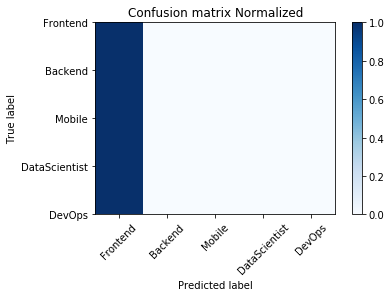

In [485]:
evaluate_prediction(y_pred, test_data['label'])

In [538]:
rf = RandomForestClassifier(n_estimators = 100, random_state = 30)

In [494]:
rf.fit(train_data_features, train_data['label'])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=30, verbose=0,
                       warm_start=False)

In [495]:
y_pred=rf.predict(test_data_features)

accuracy 0.546875
Testing F1 score: 0.4683202249484617
percision: 0.5166842819581584
recall: 0.546875
confusion matrix
 [[46  0  2  0  0]
 [16  0  6  0  0]
 [16  0 13  0  0]
 [ 6  0  2 10  0]
 [ 5  0  4  1  1]]
(row=expected, col=predicted)


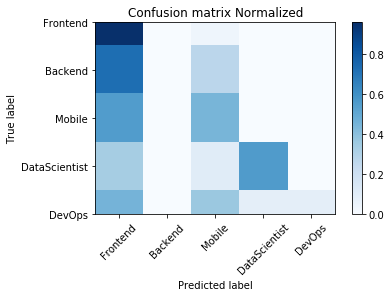

In [497]:
evaluate_prediction(y_pred, test_data['label'])

In [499]:
baseline_dt = pd.read_csv(r'C:\GH-Dataset\Git_dt_roles\baseline_dt.csv')

In [502]:
bl_dt=baseline_dt.drop('gh_login',axis=1)

In [594]:
train_data, test_data = train_test_split(bl_dt, test_size=0.1, random_state=43)

In [595]:
ttt=train_data.drop('label',axis=1)

In [596]:
rf.fit(ttt, train_data['label'])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=30, verbose=0,
                       warm_start=False)

In [597]:
te=test_data.drop('label',axis=1)

In [598]:
y_pred=rf.predict(te)

accuracy 0.5671641791044776
Testing F1 score: 0.5139485652545354
percision: 0.5473211193607513
recall: 0.5671641791044776
confusion matrix
 [[46  1  2  3  0]
 [11  2  8  0  1]
 [12  1 16  4  0]
 [ 2  1  1 10  0]
 [ 5  0  4  2  2]]
(row=expected, col=predicted)


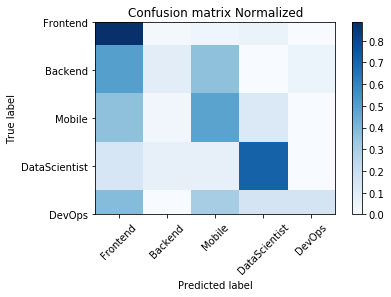

In [599]:
evaluate_prediction(y_pred, test_data['label'])

In [600]:
clf.fit(ttt, train_data['label'])

C:\Users\morad\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='rbf', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

In [601]:
y_pred = clf.predict(te)

accuracy 0.44029850746268656
Testing F1 score: 0.3478846369655482
percision: 0.338955223880597
recall: 0.44029850746268656
confusion matrix
 [[46  0  6  0  0]
 [17  0  5  0  0]
 [22  0 10  1  0]
 [ 7  0  4  3  0]
 [ 8  0  5  0  0]]
(row=expected, col=predicted)


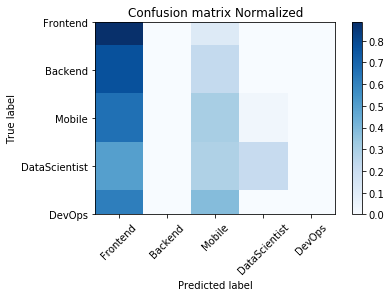

In [603]:
evaluate_prediction(y_pred, test_data['label'])

In [566]:
logreg = LogisticRegression(n_jobs=1, C=1e5)


In [604]:
logreg.fit(ttt, train_data['label'])

C:\Users\morad\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\morad\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\morad\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


LogisticRegression(C=100000.0, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=1, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [605]:
y_pred = logreg.predict(te)

accuracy 0.5447761194029851
Testing F1 score: 0.5010622874820757
percision: 0.496499644633973
recall: 0.5447761194029851
confusion matrix
 [[44  1  5  1  1]
 [12  1  6  1  2]
 [15  1 14  1  2]
 [ 2  1  0  9  2]
 [ 4  1  3  0  5]]
(row=expected, col=predicted)


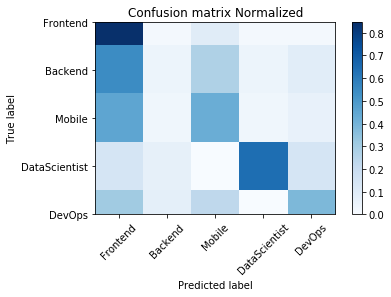

In [606]:
evaluate_prediction(y_pred, test_data['label'])

#### Issue dataset

In [608]:
#the directory of pickle files
issue_dir = r'C:\GH-Dataset\Git_dt_roles\issues'

In [741]:
#define the final DataFrame format
Issue_Corpus = pd.DataFrame(columns=['Name','u_id','bio','Repo_Name','textual_all'])

In [742]:
#loop over all files in a directory and collect required fields
issues=0
error=0
for filename in os.listdir(usr_dir):
    usr_path = os.path.join(usr_dir, filename)
    reader = open_file(usr_path)
    try:
        issue_path = os.path.join(issue_dir, filename)
        issue_reader = open_file(issue_path)
    except:
        issue_reader=None
        
    bio   = newline(str(reader['bio']))
    Name = str(reader['name'])
    try:
        u_id= str(reader['u_id'])
    except:
        u_id ="none"

        
    #RM = []
    repo_name=[]
    #repo_tags=[]
    #repo_topics=[]
    repo_text=[]
    issue_txt_all=[]
    
    if(len(reader['repository'])>4):
        for row in range(0,len(reader['repository'])):
            repo_name_tmp = str(reader['repository'][row]['repo_name'])
            #repo_RM_tmp = newline(str(reader['repository'][row]['readme']))
           # repo_tags_tmp = str(reader['repository'][row]['topics'])
            #repo_topics_tmp=newline(str(reader['repository'][row]['about']))
            
        
            repo_name.append(repo_name_tmp)
            #RM.append(repo_RM_tmp)
            #repo_tags.append(repo_tags_tmp)
            #repo_topics.append(repo_topics_tmp)  
            
           
                
            repo_text_tmp = repo_name_tmp
            
            try:
                if((issue_reader is not None) and (issue_reader['issues'][row])):
                    for j in issue_reader['issues'][row]:
                        issues=issues+1
                        issue_title= str(issue_reader['issues'][row][j]['title'])
                        issue_body= str(issue_reader['issues'][row][j]['body'])
                        issue_temp=merg_text(issue_title,issue_body)
                        repo_text_tmp= merg_text(repo_text_tmp,issue_temp)
                        issue_txt_all.append(issue_temp)
            except:
                error=error+1
            
            repo_text.append(repo_text_tmp)
            
            
            #if(reader['repository'][row]['languages']):
               # for lng in reader['repository'][row]['languages']:
                   # repo_text.append(lng)
                
        
        #if (len(dep_usr)>0):
          #  depend_tem = dep_usr.apply(lambda row: list(row[row == True].index), axis=1).reset_index()
          #  depends= merg_RM(depend_tem[0][0])
            
        text_all = merg_RM(repo_text) 
        #info_all = merg_text(text_all,depends)
    
    
        Issue_Corpus = Issue_Corpus.append({'Name':Name,'u_id':u_id,'bio':bio,'Repo_Name':repo_name,
                            'textual_all':text_all},ignore_index=True)
    

In [743]:
issues

59194

In [616]:
Issue_Corpus=Issue_Corpus[Issue_Corpus['u_id'].isin(lst_uid)].reset_index()

In [618]:
 dt1=Issue_Corpus[['Name','u_id','textual_all']]

In [619]:
merged_inner = pd.merge(left=dt1, right=dt2[['gh_login','label']], left_on='u_id', right_on='gh_login')

In [620]:
txt_dt=merged_inner[['u_id','textual_all','label']]

In [621]:
#number of words before cleaning
txt_dt['textual_all'].apply(lambda x: len(x.split(' '))).sum()

2591043

In [622]:
#split sentence in documents (Corpus['textual_all'])
sentences_stream = split_sentence(txt_dt['textual_all'])

In [623]:
#tokenize all sentences
tokenize_sentence=[]
for row in sentences_stream:
    tokenize_st = flatten_list(token_in_sentence(row))
    tokenize_sentence.append(tokenize_st)

In [624]:
#cleaning data with costum actions
processing_tokens = [str_preprocessing(sen) for sen in tokenize_sentence]

In [625]:
clean_tokens=[]
for row in processing_tokens:
    #clean_tokens.append([w for w in row if w not in ["None","none"]])
    clean_tokens.append([w for w in row if len(w) > 1])

In [626]:
bi_tmp_df = {'text_all':clean_tokens,'tags':txt_dt['u_id'],'label':txt_dt['label']}

In [627]:
bi_doc2vec_dt = pd.DataFrame(bi_tmp_df)

In [629]:
bi_doc2vec_dt=bi_doc2vec_dt[bi_doc2vec_dt['text_all'].str.len()>5].reset_index()

In [631]:
#bi_doc2vec_dt

In [632]:
bi_doc2vec_dt=bi_doc2vec_dt.drop('index',axis=1)

In [633]:
doc_tagged = bi_doc2vec_dt.apply(
    lambda r: TaggedDocument(words=r['text_all'], tags=[r.tags]), axis=1)

In [660]:
trainset, testset = train_test_split(bi_doc2vec_dt, test_size=0.1, random_state=45)

In [661]:
train=trainset.apply(
    lambda r: TaggedDocument(words=r['text_all'], tags=[r.tags]), axis=1)

In [662]:
test = testset.apply(
    lambda r: TaggedDocument(words=r['text_all'], tags=[r.tags]), axis=1)

In [666]:
issue_model_dmm = Doc2Vec(dm=1, vector_size=150, window=3, negative=5, min_count=5,epochs=20)
issue_model_dmm.build_vocab(tqdm(train.values))

100%|██████████████████████████████████████████████████████████████████████████████| 919/919 [00:00<00:00, 3243.07it/s]


In [667]:
issue_model_dmm.train(tqdm(train.values), total_examples=len(train.values), epochs=issue_model_dmm.epochs)

100%|███████████████████████████████████████████████████████████████████████████████| 919/919 [00:00<00:00, 933.58it/s]


In [668]:
%%time
y_train, X_train = vec_for_learning(issue_model_dmm, train)
y_test, X_test = vec_for_learning(issue_model_dmm, test)


Wall time: 44.5 s


In [669]:
Y_train,labels=zip(*[(label,label) for label in trainset['label']] )
Y_test,labels=zip(*[(label,label) for label in testset['label']] )

In [670]:
pd.DataFrame(Y_test)[0].value_counts()

Frontend         42
Mobile           25
Backend          16
DataScientist    11
DevOps            9
Name: 0, dtype: int64

In [671]:
u_id_lst=[]
for row in train.values:
    u_id_lst.append(row.tags[0])

In [672]:
sim_train=pd.DataFrame(columns=['u_id','cos_sim'])


In [673]:
for uid in range(0,len(u_id_lst)):
    vec_train=X_train[uid]
    username=u_id_lst[uid]
    vec_user = issue_model_dmm.docvecs[username]
    sim_train=sim_train.append({'u_id':username,'cos_sim':cos_sim(vec_train,vec_user)},ignore_index=True)

In [674]:
(len(sim_train)-len(sim_train[sim_train['cos_sim']<0.85]))/len(sim_train)

1.0

In [675]:
rf = RandomForestClassifier(n_estimators = 100, random_state = 30)

In [676]:
rf.fit(X_train,Y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=30, verbose=0,
                       warm_start=False)

In [677]:
y_pred=rf.predict(X_test)

accuracy 0.5339805825242718
Testing F1 score: 0.4756356911696717
percision: 0.5218005295675199
recall: 0.5339805825242718
confusion matrix
 [[37  1  4  0  0]
 [ 8  1  5  2  0]
 [15  1  8  1  0]
 [ 2  0  1  8  0]
 [ 4  2  2  0  1]]
(row=expected, col=predicted)


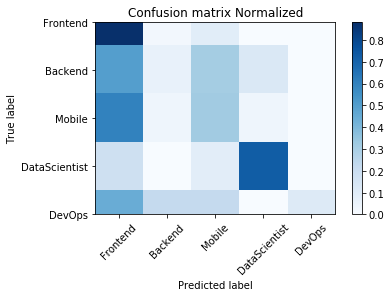

In [678]:
evaluate_prediction(y_pred, Y_test)

In [679]:
logreg = LogisticRegression(n_jobs=1, C=1e5)

In [680]:
logreg.fit(X_train, Y_train)

C:\Users\morad\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\morad\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


LogisticRegression(C=100000.0, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=1, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [681]:
y_pred = logreg.predict(X_test)

accuracy 0.47572815533980584
Testing F1 score: 0.4752531090690652
percision: 0.5069754409560234
recall: 0.47572815533980584
confusion matrix
 [[24  0  8  4  6]
 [ 5  2  4  2  3]
 [ 3  2 12  5  3]
 [ 1  1  1  8  0]
 [ 0  2  2  2  3]]
(row=expected, col=predicted)


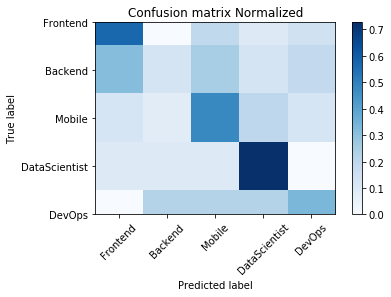

In [682]:
evaluate_prediction(y_pred, Y_test)

In [683]:
clf = svm.SVC()

In [684]:
clf.fit(X_train, Y_train)

C:\Users\morad\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='rbf', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

In [685]:
y_pred = clf.predict(X_test)

accuracy 0.6310679611650486
Testing F1 score: 0.5948584414297489
percision: 0.6339259146489146
recall: 0.6310679611650486
confusion matrix
 [[38  0  4  0  0]
 [ 9  2  3  2  0]
 [11  0 13  1  0]
 [ 1  1  1  8  0]
 [ 2  1  2  0  4]]
(row=expected, col=predicted)


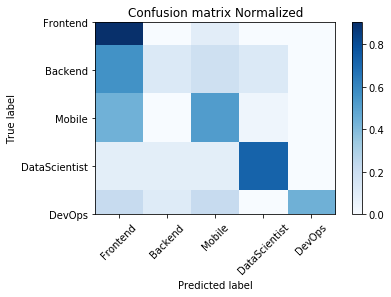

In [686]:
evaluate_prediction(y_pred, Y_test)

## API

In [744]:
language_Contribution = pd.read_csv(r'C:\GH-Dataset\Git_dt_roles\language_Contribution_3.csv',lineterminator='\n')

In [745]:
lng_contr_notna=language_Contribution[language_Contribution['APIs'] != '[]'].reset_index()

In [746]:
lng_contr_notna=lng_contr_notna.drop('index',axis=1)

In [747]:
len(lng_contr_notna)

552378

In [748]:
def split_APIs(ls):
    snts = [re.split('( )|\/|<|>|;|,|\(|\)|\n|\r|\[|\]|\{|\}',doc) for doc in ls]
    return snts

In [749]:
#flat a list of lists into a list
def flatten_list(sentences):
    flatList = [ item for elem in sentences for item in elem]
    return flatList

In [750]:
from ast import literal_eval

In [751]:
str_to_list=[literal_eval(doc) for doc in lng_contr_notna['APIs']]

In [752]:
sp_APIs=[]
i=0

In [753]:
while i<552378:
    j=i+10000
    for doc in str_to_list[i:j]:
        sp_APIs.append(split_APIs(doc))
    i=j

In [754]:
flatt_API=[]
i=0

In [755]:
#flatt_API=[flatten_list(doc) for doc in sp_APIs]

while i<552378:
    j=i+10000
    for doc in sp_APIs[i:j]:
        flatt_API.append(flatten_list(doc))
    i=j

In [756]:
all_stopwords=STOPWORDS.union(set(['', ' ',None,'using','include','from','import','Import','From','require', 'use','crate','library','var','\n','new',
              'return','*',"'*'",'\r']))

In [757]:
clean_APIs=[]
for doc in flatt_API:
    clean_APIs.append([word for word in doc if not word in all_stopwords])

In [30]:
all_in_one = pd.read_csv(r'C:\GH-Dataset\Git_dt_roles\all_in_one_2.csv')

In [239]:
train,test = train_test_split(all_in_one,test_size=0.2, random_state=50)

In [240]:

X_dt=train.iloc[:, 1:201]

In [241]:
X_train=X_dt.to_numpy()


In [242]:

X_test_dt=test.iloc[:, 1:201]

In [243]:
X_test=X_test_dt.to_numpy()

In [244]:
Y_train=train['label']

In [245]:
Y_test=test['label']

In [246]:
logreg = LogisticRegression(n_jobs=1, C=1e5)

In [247]:
logreg.fit(X_train, train['label'])
y_pred = logreg.predict(X_test)

C:\Users\morad\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\morad\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\morad\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


accuracy 0.416
Testing F1 score: 0.4143842732562251
percision: 0.42008985507246377
recall: 0.416
confusion matrix
 [[25  5  7  3  3]
 [ 5  4  5  2  2]
 [ 8  7 11  5  5]
 [ 4  0  2  9  3]
 [ 4  0  2  1  3]]
(row=expected, col=predicted)


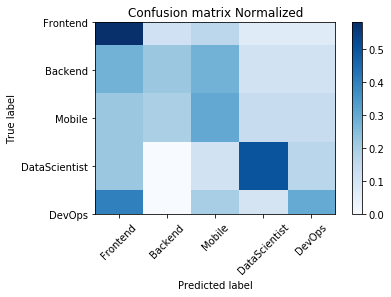

In [248]:
evaluate_prediction(y_pred, Y_test)

In [127]:
from sklearn.ensemble import RandomForestClassifier

In [150]:
rf = RandomForestClassifier(n_estimators = 100, random_state = 30)

In [151]:
rf.fit(X_train,Y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=30, verbose=0,
                       warm_start=False)

accuracy 0.44
Testing F1 score: 0.4293386310590024
percision: 0.43612549019607844
recall: 0.44
confusion matrix
 [[24  6  5  2  1]
 [ 6  4  3  3  0]
 [14  3 17  1  4]
 [ 4  4  1  9  0]
 [ 3  3  4  3  1]]
(row=expected, col=predicted)


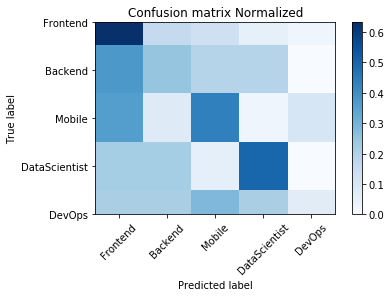

In [152]:
evaluate_prediction(y_pred, Y_test)

In [131]:
from sklearn import svm

In [249]:
clf = svm.SVC()

In [250]:
clf.fit(X_train, Y_train)

C:\Users\morad\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='rbf', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

In [251]:
y_pred = clf.predict(X_test)

accuracy 0.464
Testing F1 score: 0.38580625476735314
percision: 0.409984962406015
recall: 0.464
confusion matrix
 [[40  0  3  0  0]
 [12  0  6  0  0]
 [26  0 10  0  0]
 [ 9  0  1  8  0]
 [ 8  0  1  1  0]]
(row=expected, col=predicted)


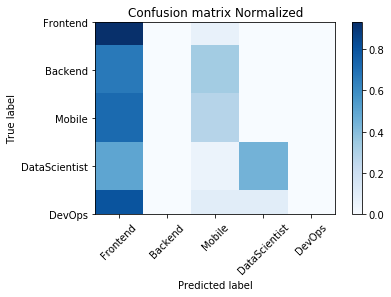

In [253]:
evaluate_prediction(y_pred, Y_test)